<a href="https://colab.research.google.com/github/qsquentinsmith/minnesota_real_estate_analysis/blob/main/real_estate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Estate Analysis

In [ ]:
import pandas as pd
import numpy as np
import pickle
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

from skimage.io import imread
from skimage.transform import resize
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers.normalization import BatchNormalization

from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation, Reshape, Dropout, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.models import Model

import re
import string
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet, subjectivity
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import patsy

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Get Image Data

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# get data
df1 = pd.read_csv('/content/drive/MyDrive/cleaned_housing_data.csv')

In [ ]:
# Install kora, a library containing a version of selenium that can be used in google colab
!pip install kora -q
from kora.selenium import wd
import os 
import time
import requests
import io
from PIL import Image, ImageOps
import hashlib

First a few helper functions are defined that will aid with scraping images.


*   fetch_image_urls_google: retrieve the images from the results.
*   persist_image: saves the images to ./Images for use later on.
*   search_and_download: Iterates through a list to create the query for retrieving the images. The list contains the addresses for the house images that we require.

In [ ]:
# Helper functions for scraping images from google images 

def fetch_image_urls_google(query:str, max_links_to_fetch:int, wd:wd, sleep_between_interactions:int=1):
    def scroll_to_end(wd_old):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"\n{query}: Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"{query}: Found: {len(image_urls)} image links, done!")
                break
        else:
            print(f"{query}: Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls


def persist_image(folder_path:str, url:str, verbose:bool=True):
    success = False
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")
        
    try:
        image_file = io.BytesIO(image_content)
        Image.url = ''
        image = Image.open(image_file).convert('RGB')
        image.url = url
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        if verbose:  print(f"SUCCESS - saved {url} - as {file_path}")
        success = True
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")
    return success
    

def search_and_download(search_term:str, target_path:str='./images', number_images:int=5, verbose:bool=True):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    try_urls = fetch_image_urls_google(search_term, number_images, wd=wd, sleep_between_interactions=0.5)

    count, urls = 0, []      # save count of success and urls whose images were successfully saved
    for url in try_urls:
        rc = persist_image(target_folder, url, verbose=verbose)
        if rc:
            count += 1
            urls.append(url)
    
    print(f"{search_term}: Expected {number_images}, succeeded at saving {count}.")
    return count, urls 

These next two code cells will instantiate and populate *search_terms* which is the list that contains the addresses for the houses that we want to retrieve the images for. The query includes "house listing" at the end of each address so that there is a higher chance of retrieving an image of the exterior of the house vs the interior which would not be helpful for our case.

In [ ]:
# Create new dataframe with pid and address for scraping
df_addresses_only = df1[['pid','address_long']]

# Verify
df_addresses_only.head(5)

,pid,address_long
0,5708235,5027-Nob-Hill-Drive-Edina-MN-55439
1,5618755,683-Oakgreen-Avenue-Court-N-West-Lakeland-Twp-...
2,5501312,12299-Lucerne-Trail-Lakeville-MN-55044
3,5628081,2875-Rodeo-Drive-NE-Blaine-MN-55449
4,5570154,7525-159th-Street-Savage-MN-55378


In [ ]:
# List containing addresses to be scraped 
search_terms = []
count = 0
for address in df_addresses_only['address_long']:
  # query = address + " house listing" # Adding "house listing" for a higher chance of retrieving an image of the exterior
  search_terms.append(query)
  count += 1
  if (count == 50): # Amount of addresses to add to the search list (i.e if count is 3, then only 3 addresses will be added to the search list)
    break          # WARNING: If count is set too high, google may block your ip from scraping for a few hours

# Verify 
print(search_terms)

['5027-Nob-Hill-Drive-Edina-MN-55439 house listing', '683-Oakgreen-Avenue-Court-N-West-Lakeland-Twp-MN-55082 house listing', '12299-Lucerne-Trail-Lakeville-MN-55044 house listing', '2875-Rodeo-Drive-NE-Blaine-MN-55449 house listing', '7525-159th-Street-Savage-MN-55378 house listing', '7351-159th-Street-Savage-MN-55378 house listing', '15624-Pennsylvania-Avenue-Savage-MN-55372 house listing', '4749-Columbus-Avenue-Minneapolis-MN-55407 house listing', '510-Magnolia-Lane-N-Plymouth-MN-55441 house listing', '10701-Jersey-Court-N-Brooklyn-Park-MN-55445 house listing', '12675-Dodd-Court-Rosemount-MN-55068 house listing', '500-Mississippi-River-Boulevard-N-Saint-Paul-MN-55104 house listing', '4894-Mayelin-Avenue-NE-Saint-Michael-MN-55376 house listing', '15554-71st-Avenue-N-Maple-Grove-MN-55311 house listing', '5633-Logan-Avenue-S-Minneapolis-MN-55419 house listing', '693-142nd-Lane-NW-Andover-MN-55304 house listing', '100-Jersey-Avenue-N-Golden-Valley-MN-55427 house listing', '11743-London-S

Cateogry is a class that is used to make it easier to parse through the images and urls once retrieved.

In [ ]:
# Class to contain images/url
class Category():
    def __init__(self):
      self.images = []
      self.urls = []
    
    def retrieveImages(self):
      return (self.images)

    def retrieveUrls(self):
      return (self.urls)

    def retrieveCombinedImagesAndUrls(self):
      temp = []
      for image, url in self.images, self.urls:
          nestedList = [image, url]
          temp.append(nestedList)

Using the previously created helper functions and list *search_terms*, scrape google images for all the adddress within, storing the results at './images' for use later on. Also stored are the URLs of where the images were retrieved from, this will come in use later on.

In [ ]:
# Number of images to retrieve for each address
number_images = 1 # WARNING: Do not set too high otherwise google will block your ip from scraping for a few hours.

# Where to store images
target_path = './images'           

# Clear any previous searches 
!rm -rf $target_path                

# Retrieve house images
dataset = dict.fromkeys(search_terms, Category() )
urlDataset = dict()
print("dataset.keys = ", list(dataset.keys()))
for term in dataset.keys():
  new_term = term.replace("house", "")
  new_term = new_term.replace("listing", "")
  new_term = new_term.rstrip()
  try:
    count, urls = search_and_download(search_term = term, target_path=target_path, number_images=number_images)
    urlDataset[new_term] = urls
  except (ConnectionError) as e:
    break 

# Output all that was retrieved
dataset

dataset.keys =  ['5027-Nob-Hill-Drive-Edina-MN-55439 house listing', '683-Oakgreen-Avenue-Court-N-West-Lakeland-Twp-MN-55082 house listing', '12299-Lucerne-Trail-Lakeville-MN-55044 house listing', '2875-Rodeo-Drive-NE-Blaine-MN-55449 house listing', '7525-159th-Street-Savage-MN-55378 house listing', '7351-159th-Street-Savage-MN-55378 house listing', '15624-Pennsylvania-Avenue-Savage-MN-55372 house listing', '4749-Columbus-Avenue-Minneapolis-MN-55407 house listing', '510-Magnolia-Lane-N-Plymouth-MN-55441 house listing', '10701-Jersey-Court-N-Brooklyn-Park-MN-55445 house listing', '12675-Dodd-Court-Rosemount-MN-55068 house listing', '500-Mississippi-River-Boulevard-N-Saint-Paul-MN-55104 house listing', '4894-Mayelin-Avenue-NE-Saint-Michael-MN-55376 house listing', '15554-71st-Avenue-N-Maple-Grove-MN-55311 house listing', '5633-Logan-Avenue-S-Minneapolis-MN-55419 house listing', '693-142nd-Lane-NW-Andover-MN-55304 house listing', '100-Jersey-Avenue-N-Golden-Valley-MN-55427 house listing',

{'100-Jersey-Avenue-N-Golden-Valley-MN-55427 house listing': <__main__.Category at 0x7f71e02af250>,
 '10010-Juniper-Avenue-N-Brooklyn-Park-MN-55443 house listing': <__main__.Category at 0x7f71e02af250>,
 '10060-Honeysuckle-Avenue-N-Brooklyn-Park-MN-55443 house listing': <__main__.Category at 0x7f71e02af250>,
 '10509-Scott-Avenue-N-Brooklyn-Park-MN-55443 house listing': <__main__.Category at 0x7f71e02af250>,
 '10701-Jersey-Court-N-Brooklyn-Park-MN-55445 house listing': <__main__.Category at 0x7f71e02af250>,
 '10910-237th-Avenue-NW-Zimmerman-MN-55398 house listing': <__main__.Category at 0x7f71e02af250>,
 '11315-37th-Avenue-N-Plymouth-MN-55441 house listing': <__main__.Category at 0x7f71e02af250>,
 '11743-London-Street-NE-Blaine-MN-55449 house listing': <__main__.Category at 0x7f71e02af250>,
 '12299-Lucerne-Trail-Lakeville-MN-55044 house listing': <__main__.Category at 0x7f71e02af250>,
 '12675-Dodd-Court-Rosemount-MN-55068 house listing': <__main__.Category at 0x7f71e02af250>,
 '1337-Ove

Verify that the URL dictionary was properly created

In [ ]:
# Check url dictionary
print(urlDataset)

{'5027-Nob-Hill-Drive-Edina-MN-55439': ['https://ap.rdcpix.com/1b58a82bebfc1566f84389a135510582l-m1821058472xd-w1020_h770_q80.jpg'], '683-Oakgreen-Avenue-Court-N-West-Lakeland-Twp-MN-55082': ['https://ap.rdcpix.com/c17320241e46f725a05e5548a7c4349dl-m840726869xd-w1020_h770_q80.jpg'], '12299-Lucerne-Trail-Lakeville-MN-55044': ['https://ap.rdcpix.com/9b9b5159f95f8657bb91c8ff42d1c419l-m3928798713xd-w1020_h770_q80.jpg'], '2875-Rodeo-Drive-NE-Blaine-MN-55449': ['https://photos.zillowstatic.com/fp/ea0184d33bb947233f7122bff7edd444-p_d.jpg'], '7525-159th-Street-Savage-MN-55378': ['https://ssl.cdn-redfin.com/photo/114/bigphoto/960/5568960_H.jpg'], '7351-159th-Street-Savage-MN-55378': ['https://ap.rdcpix.com/0c49c68922da45328820ba122af29303l-m3881103336xd-w1020_h770_q80.jpg'], '15624-Pennsylvania-Avenue-Savage-MN-55372': ['https://images.marketleader.com/HouseImages/MINNESOTA/025/f_5502025_01.jpg'], '4749-Columbus-Avenue-Minneapolis-MN-55407': ['https://photos.zillowstatic.com/fp/802bc3431f9391a7

The dictionary is set up so that the key are the addresses and the value are the respective URLs. The issue is that each url is store in a single element list containing only that url for each key. This will make it much more difficult to work with later so we will first convert it from a list to a string.

In [ ]:
# Convert url list within dictionary to string
urlDatasetTemp = dict()
for key in urlDataset.keys():
  listToStr = urlDataset.get(key)
  listToStr = "".join(listToStr)
  urlDatasetTemp[key] = listToStr

# Convert dictionary with url to dataframe
df_urls = pd.DataFrame(urlDatasetTemp.items(), columns=["address_long", "url"])
df_urls['address_long'] = df_urls['address_long'].str.lower()

# Verify
df_urls.head(5)

,address_long,url
0,5027-nob-hill-drive-edina-mn-55439,https://ap.rdcpix.com/1b58a82bebfc1566f84389a1...
1,683-oakgreen-avenue-court-n-west-lakeland-twp-...,https://ap.rdcpix.com/c17320241e46f725a05e5548...
2,12299-lucerne-trail-lakeville-mn-55044,https://ap.rdcpix.com/9b9b5159f95f8657bb91c8ff...
3,2875-rodeo-drive-ne-blaine-mn-55449,https://photos.zillowstatic.com/fp/ea0184d33bb...
4,7525-159th-street-savage-mn-55378,https://ssl.cdn-redfin.com/photo/114/bigphoto/...


Now that it has been converted to a string, a dataframe containing all the needed information will be created. First a dataframe containing the *pid*, *sell_price*, *list_price*, *address_long* will be created as the base dataframe to merge later on.

In [ ]:
# New dataframe with only pid, address, sell_price, and list_price for parsing
df_images = df1[['pid', 'sell_price','list_price', 'address_long']].copy()

# Convert address to lowercase for parsing
df_images['address_long'] = df_images['address_long'].str.lower()

# Verify
df_images.head(5)

,pid,sell_price,list_price,address_long
0,5708235,1275000.0,1300000.0,5027-nob-hill-drive-edina-mn-55439
1,5618755,845000.0,849900.0,683-oakgreen-avenue-court-n-west-lakeland-twp-...
2,5501312,825000.0,825000.0,12299-lucerne-trail-lakeville-mn-55044
3,5628081,823000.0,850000.0,2875-rodeo-drive-ne-blaine-mn-55449
4,5570154,737467.0,737467.0,7525-159th-street-savage-mn-55378


Now a new dataframe will be created that contains the addresses of the houses and their respective image. To do so, we first fetch the images at /content/images/[house address] and then store it in dictionary as the value where the key is the address. This is then turned into a dataframe that will be merged with the one above.

In [ ]:
# Create a dictionary of the folders containing the images to later be turned into a dataframe
imageDict = dict()
for folder in os.listdir('/content/images'):

  # Removes _house_listing from folder name for parsing
  folder_original = folder.replace("_house_listing", "")

  for image in os.listdir(f'/content/images/{folder}'): 
    
    imageDict[folder_original] = image

# Create dataframe to compare later on
df_compare_temp = pd.DataFrame(imageDict.items(), columns=["address_long", "image"])

# Verify
df_compare_temp.head(5)

,address_long,image
0,5908-columbus-avenue-minneapolis-mn-55417,e31900d8ec.jpg
1,6402-langer-lane-lino-lakes-mn-55038,fad46ff3f2.jpg
2,12299-lucerne-trail-lakeville-mn-55044,3270f7281b.jpg
3,10701-jersey-court-n-brooklyn-park-mn-55445,b08b32f94c.jpg
4,1794-157th-lane-nw-andover-mn-55304,a041f13f0a.jpg


Now that our two dataframes are created, we inner join them to create a dataframe that contains all the needed information.

In [ ]:
# Merge dataframe containing pid, address, sell_price, list_price, and image
df_images_final = df_images.merge(df_compare_temp, on="address_long", how="inner")
df_images_final.head(5)

,pid,sell_price,list_price,address_long,image
0,5708235,1275000.0,1300000.0,5027-nob-hill-drive-edina-mn-55439,2fbad01710.jpg
1,5618755,845000.0,849900.0,683-oakgreen-avenue-court-n-west-lakeland-twp-...,b3ea780d30.jpg
2,5501312,825000.0,825000.0,12299-lucerne-trail-lakeville-mn-55044,3270f7281b.jpg
3,5628081,823000.0,850000.0,2875-rodeo-drive-ne-blaine-mn-55449,f55b080a43.jpg
4,5570154,737467.0,737467.0,7525-159th-street-savage-mn-55378,bd7c1b2362.jpg


A third dataframe *df_urls* is merged with the above two. This new dataframe will contain the URLs alongside the information collected above.

In [ ]:
# Add URL to dataframe using previously created dataframe
df_images_final = df_images_final.merge(df_urls, on="address_long", how='inner')
df_images_final.head(5)

,pid,sell_price,list_price,address_long,image,url
0,5708235,1275000.0,1300000.0,5027-nob-hill-drive-edina-mn-55439,2fbad01710.jpg,https://ap.rdcpix.com/1b58a82bebfc1566f84389a1...
1,5618755,845000.0,849900.0,683-oakgreen-avenue-court-n-west-lakeland-twp-...,b3ea780d30.jpg,https://ap.rdcpix.com/c17320241e46f725a05e5548...
2,5501312,825000.0,825000.0,12299-lucerne-trail-lakeville-mn-55044,3270f7281b.jpg,https://ap.rdcpix.com/9b9b5159f95f8657bb91c8ff...
3,5628081,823000.0,850000.0,2875-rodeo-drive-ne-blaine-mn-55449,f55b080a43.jpg,https://photos.zillowstatic.com/fp/ea0184d33bb...
4,5570154,737467.0,737467.0,7525-159th-street-savage-mn-55378,bd7c1b2362.jpg,https://ssl.cdn-redfin.com/photo/114/bigphoto/...


Now that our final dataframe is setup, this will test whether or not it is created as we wanted. If all went well, the image should be able to display from the URL. 

**Note**: The *image* column is only the name of the file as the image cannot be displayed inline with the dataframe. 

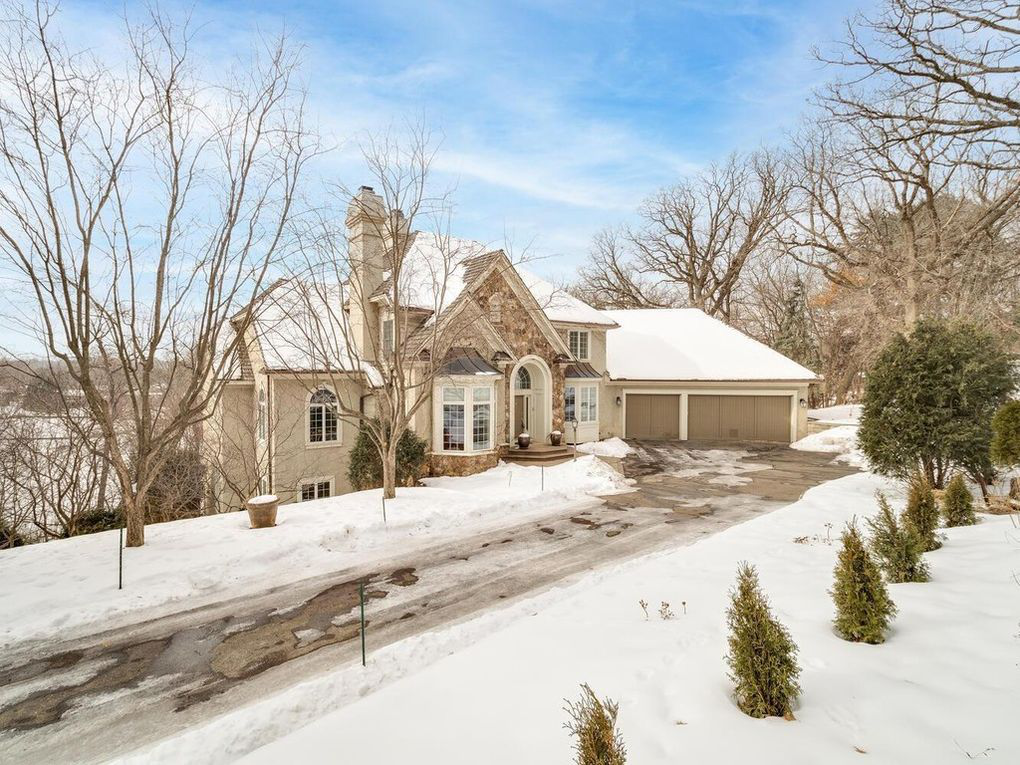

In [ ]:
# Test open 1 image
from PIL import Image
import requests

urltest = df_images_final['url'][0]
Image.open(requests.get(urltest, stream=True).raw)

Afterwards, the path of the image will be retrieved as the image will be stored on google colab

In [ ]:
imagePathDict = dict()
for folder in os.listdir('/content/images'):

  # Removes _house_listing from folder name for parsing
  folder_original = folder.replace("_house_listing", "")

  for image in os.listdir(f'/content/images/{folder}'):   
    # Path of the file to be added to dataframe
    pathFile = "/content/images/" + folder + "/" + image

    # Store in dictionary 
    imagePathDict[folder_original] = pathFile

# Create dataframe to compare later on
df_path_temp = pd.DataFrame(imagePathDict.items(), columns=["address_long", "path"])

# Verify 
df_path_temp.head(5)

,address_long,path
0,5908-columbus-avenue-minneapolis-mn-55417,/content/images/5908-columbus-avenue-minneapol...
1,6402-langer-lane-lino-lakes-mn-55038,/content/images/6402-langer-lane-lino-lakes-mn...
2,12299-lucerne-trail-lakeville-mn-55044,/content/images/12299-lucerne-trail-lakeville-...
3,10701-jersey-court-n-brooklyn-park-mn-55445,/content/images/10701-jersey-court-n-brooklyn-...
4,1794-157th-lane-nw-andover-mn-55304,/content/images/1794-157th-lane-nw-andover-mn-...


Now to inner join to finish the dataframe  

In [ ]:
df_images_final = df_images_final.merge(df_path_temp, on="address_long", how='inner')
df_images_final.head(5)

,pid,sell_price,list_price,address_long,image,url,path
0,5708235,1275000.0,1300000.0,5027-nob-hill-drive-edina-mn-55439,2fbad01710.jpg,https://ap.rdcpix.com/1b58a82bebfc1566f84389a1...,/content/images/5027-nob-hill-drive-edina-mn-5...
1,5618755,845000.0,849900.0,683-oakgreen-avenue-court-n-west-lakeland-twp-...,b3ea780d30.jpg,https://ap.rdcpix.com/c17320241e46f725a05e5548...,/content/images/683-oakgreen-avenue-court-n-we...
2,5501312,825000.0,825000.0,12299-lucerne-trail-lakeville-mn-55044,3270f7281b.jpg,https://ap.rdcpix.com/9b9b5159f95f8657bb91c8ff...,/content/images/12299-lucerne-trail-lakeville-...
3,5628081,823000.0,850000.0,2875-rodeo-drive-ne-blaine-mn-55449,f55b080a43.jpg,https://photos.zillowstatic.com/fp/ea0184d33bb...,/content/images/2875-rodeo-drive-ne-blaine-mn-...
4,5570154,737467.0,737467.0,7525-159th-street-savage-mn-55378,bd7c1b2362.jpg,https://ssl.cdn-redfin.com/photo/114/bigphoto/...,/content/images/7525-159th-street-savage-mn-55...


In [ ]:
df_images_final.dtypes

pid               int64
sell_price      float64
list_price      float64
address_long     object
image            object
url              object
path             object
dtype: object

In [ ]:
# # copy data frame to change type
# df3 = df_images_final.copy()

In [ ]:
# # Go through pid list and only keep numeric string values
# for i in df3.index.values:
#   if not df3['pid'][i].isnumeric():
#     df3 = df3.drop(i)

In [ ]:
# # Since they are all numeric we can change the types for merging in analysis
# df3['pid']= df3['pid'].astype(int)

In [ ]:
# Because we will be merging into the metadata we can delete some of these columns for now
df3 = df_images_final[['pid', 'address_long', 'image', 'url', 'path']]

In [ ]:
df3.shape

(52, 5)

Functions to prepare the image for processing later on

# Analysis

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# get data
df1 = pd.read_csv('/content/drive/MyDrive/cleaned_housing_data.csv')

df2 = pd.read_csv('/content/drive/MyDrive/cleaned_housing_description_data_v1.csv')

In [ ]:
df1 = df1.drop(df1.columns[[0]], axis=1)
df2 = df2.drop(df2.columns[[0]], axis=1)

In [ ]:
df1.dtypes

pid                         int64
sell_date                  object
sell_price                float64
list_price                float64
address_long               object
                           ...   
sewer[T.private_sewer]    float64
sewer[T.shared_sewer]     float64
water[T.n/a]              float64
water[T.private_water]    float64
water[T.shared_water]     float64
Length: 203, dtype: object

In [ ]:
df2.dtypes

pid                   int64
description_clean    object
dtype: object

In [ ]:
df = pd.merge(df1, df2, on=['pid'], how='outer')

In [ ]:
len(df)

101669

In [ ]:
df = df.dropna()

In [ ]:
len(df)

57872

In [ ]:
address = df.pop('address_long')
sale_price = df.pop('sell_price')
home_description = df.pop('description_clean')
df = df.drop(['sell_date', 'city', 'county', 'property_type', 'zoning', 'list_price', 'common_wall', 'school_district'], axis=1)
df = df.drop(df.columns[[0]], axis=1)



In [ ]:
df.head(3)

,zip_code,built,num_bath,num_bed,fin_sqft,above_gd_sqft,below_gd_sqft,num_fireplaces,num_garage_spaces,foundation_size,lot,association_fee,tax_year,annual_taxes,forced_air_heater,boiler_heater,hot_water_heater,radiant_heat,heat_pump,dual_heat,ductless_mini_split_heat,baseboard_heater,geothermal_heat,other_heat,lower_level_family_room,main_level_family_room,loft,entertainment/media_center,vaulted_ceilings,great_room,formal_dining_room,informal_dining_room,breakfast_area/breakfast_bar,shed,additional_garage,barn,chicken_coop,hottub,workshop,studio,...,pool[T.belowground:heated:indoor:outdoor:shared],pool[T.belowground:heated:indoor:shared],pool[T.belowground:heated:outdoor],pool[T.belowground:heated:outdoor:shared],pool[T.belowground:heated:shared],pool[T.belowground:indoor],pool[T.belowground:indoor:outdoor],pool[T.belowground:indoor:outdoor:shared],pool[T.belowground:indoor:shared],pool[T.belowground:outdoor],pool[T.belowground:outdoor:shared],pool[T.belowground:shared],pool[T.heated],pool[T.heated:indoor],pool[T.heated:indoor:outdoor],pool[T.heated:indoor:outdoor:shared],pool[T.heated:indoor:shared],pool[T.heated:outdoor],pool[T.heated:outdoor:shared],pool[T.heated:shared],pool[T.indoor],pool[T.indoor:outdoor],pool[T.indoor:outdoor:shared],pool[T.indoor:shared],pool[T.none],pool[T.outdoor],pool[T.outdoor:shared],pool[T.shared],fuel[T.natural_gas],fuel[T.oil],fuel[T.other],fuel[T.propane],fuel[T.wood],sewer[T.none],sewer[T.other],sewer[T.private_sewer],sewer[T.shared_sewer],water[T.n/a],water[T.private_water],water[T.shared_water]
0,55439.0,1993.0,5.0,5.0,5979.0,4234.0,1745.0,3.0,3.0,2915.0,0.81,0.0,2020.0,19173.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55082.0,2001.0,4.0,4.0,4437.0,3329.0,1108.0,3.0,3.0,1225.0,2.82,200.0,2019.0,5169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,55044.0,1997.0,4.0,5.0,6192.0,2708.0,3484.0,4.0,6.0,2708.0,11.16,0.0,2020.0,9272.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# sort most important metadata features by p-value
X = df[:]

y = sale_price[:]

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('p-value', 'feature')
features

p-value feature


[(0.0, 'above_gd_sqft'),
 (0.0, 'ac[T.geothermal]'),
 (0.0, 'air_to_air_exchange'),
 (0.0, 'annual_taxes'),
 (0.0, 'association_fee'),
 (0.0, 'below_gd_sqft'),
 (0.0, 'boat_slip'),
 (0.0, 'dock'),
 (0.0, 'entertainment/media_center'),
 (0.0, 'exercise_room'),
 (0.0, 'ext_material[T.cement]'),
 (0.0, 'fin_sqft'),
 (0.0, 'foundation_size'),
 (0.0, 'fuel[T.wood]'),
 (0.0, 'great_room'),
 (0.0, 'humidifier'),
 (0.0, 'kitchen_island'),
 (0.0, 'lot'),
 (0.0, 'num_bath'),
 (0.0, 'num_fireplaces'),
 (0.0, 'pool[T.aboveground:belowground:heated:indoor:outdoor]'),
 (0.0, 'pool[T.aboveground:belowground:heated]'),
 (0.0, 'pool[T.aboveground:outdoor:shared]'),
 (0.0, 'pool[T.belowground:heated:shared]'),
 (0.0, 'pool[T.heated:shared]'),
 (0.0, 'pool[T.indoor:outdoor:shared]'),
 (0.0, 'pool[T.shared]'),
 (0.0, 'sewer[T.other]'),
 (0.0, 'wall_oven'),
 (0.0, 'wet_bar'),
 (6.135584276565987e-309, 'pool[T.belowground:heated:outdoor]'),
 (3.4129696056014e-308, 'french_doors'),
 (6.2031145096622086e-291,

In [ ]:
#vectorize the realtor description
tfidf = CountVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)
tfidf_vecs = tfidf.fit_transform(home_description)
realtor = pd.DataFrame(tfidf_vecs.todense(), 
             columns=tfidf.get_feature_names(), index = home_description.index.values
            )
del realtor['fit'] #very strange but cant use kfolds if this is a column name
realtor.head()

,abasement,abed,ability,able,ably,abode,abound,abounds,aboveground,abr,absolute,absolutely,abundance,abundant,abuts,abutting,ac,acacia,academy,accent,accented,accenting,accents,accentuate,accentuated,accept,acceptable,accepted,access,accessed,accesses,accessibility,accessible,accessing,accessories,accessory,acclaimed,accommodate,accommodates,accommodating,...,wyoming,xcel,xerxes,xl,yacht,yard,yards,yd,year,yearly,years,yellow,yep,yer,yes,yesteryear,ymca,yo,yoga,york,young,yr,yrs,ys,zachary,zane,zat,zen,zero,zi,zimmerman,zinger,zip,zone,zoned,zones,zoning,zoo,zoom,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # takes over 1 hour. Doesn't seem to work
# #find most important realtor words by p-value
# X = realtor[:]

# y = sale_price[:]

# X_new = SelectKBest(chi2, k=2).fit(X, y)

# features = []
# for i, column in enumerate(X.columns):
#     features.append((X_new.pvalues_[i], column))
# features.sort()
# print('p-value', 'feature')
# features

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
#find most positive and negative realtor descriptions 
# and create a column for sentiment in the feature matrix

#clean up text
def remove_mypunct(corpus):

    corpus = map(lambda x: re.sub(r"(#|@|http)\S+", "", x), corpus) #get rid of hashtags 
    corpus = map(lambda x: re.sub(r"(\t|\n|\v|…|“|”)", "", x), corpus) #get rid of whitesape
    corpus = map(lambda x:  re.sub(r"""\w*\d\w*""", ' ', x.lower()), corpus) #get rid of numbers
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    corpus = map(lambda x: punc_re.sub(' ', x), corpus)
    corpus = map(lambda x: re.sub('[\W_]+', " ", x), corpus) #get rid of emojis

    return list(corpus)

#calculate sentiment
sid = SentimentIntensityAnalyzer()
score_tuples = []
score = []

for i in home_description.index.values:
    clean_house = remove_mypunct([home_description[i]])
    ss = sid.polarity_scores(clean_house[0])
    score_tuples.append((float(ss['compound']), home_description[i], i))
    score.append(float(ss['compound']))
    df.loc[i, 'sentiment'] = float(ss['compound'])
    # df.set_value(i, 'sentiment', float(ss['compound']))
score_tuples.sort(reverse = True)
                 
print(np.mean(score)) 
      
for i in range(5):
    print(score_tuples[i])



0.8243338108238871
(0.9985, "Description Classic Move In ready Rambler style home in the heart of Champlin Beautiful 5 bedroom home with a four season breeze way Original hardwood floors throughout the main level 3 Bedrooms on the main level with two more in the lower makes this a great home for the family Large 1 3 acres corner lot means plenty of play area Close to schools and shopping This is a great home 5695588 02 26 2021 283000 250000 308253 6925 Empire Lane N Maple Grove MN 55311 55311 1979 Maple Grove Hennepin Single Family 2 4 2256 1193 1063 Range Microwave Dishwasher Refrigerator Was her Dryer Water Softener Owned Disposal 1 Full Finished Drain Tiled Sump Pump Daylight Lookout Windows No Forced Air Central Air Deck Kitchen Window Tiled Floors Wood Siding Brick Stone 2 1193 None None None None 2 None Eat In Kitchen Living Dining Room Lower Level Family Room 0 33 45 08077800 93 46048000 Residential Single Family 279 2021 3598 Natural Gas City Sewer Connected City Water Connecte

In [ ]:
# #sort most important metadata features by p-value
# df['sentiment'] = df['sentiment'] + 1 #can only work with nonnegative data
# X = df[:]

# y = sale_price[:]

# X_new = SelectKBest(chi2, k=2).fit(X, y)

# features = []
# for i, column in enumerate(X.columns):
#     features.append((X_new.pvalues_[i], column))
# features.sort()
# print('p-value', 'feature')
# features

In [ ]:
def my_regressor(X,y, estimator, n, svd, normalize):
    
    if svd == 'yes': #if you want to reduce dimensions before using regression
        if normalize == 'yes':
                svd_pipe = [('scaler', StandardScaler()), #only add in normalizer for realtor word data
                ('lsa', TruncatedSVD(n)),
                ('normalizer', Normalizer())]
        else:
                svd_pipe = [('scaler', StandardScaler()),
                    ('lsa', TruncatedSVD(n))]

    
        svd_pipeline = Pipeline(svd_pipe)
        new_columns = svd_pipeline.fit_transform(X)
    
        X = pd.DataFrame(new_columns)
    
    pipeline = [('scaler', StandardScaler())]
    
    if estimator == 'gradient_boosting':
        pipeline.append(('estimator', GradientBoostingRegressor(n_estimators = 300)))
        
    elif estimator == 'MLP':
        pipeline.append(('estimator', MLPRegressor(
        hidden_layer_sizes=(300,),
        solver='lbfgs',
        verbose=True,
        activation='relu',
        learning_rate='constant',
        early_stopping=True,
        max_iter=50,
        batch_size = 15)))
        
    else:
        print('I dont know that estimator.')
        return None

    pipeline = Pipeline(pipeline) 
    
    adj_r2_train = []
    adj_r2_test = []

    MSE_train = []
    MSE_test = []
    
    MAE_train = []
    MAE_test = []
    
    kf = KFold(n_splits=5, shuffle = True)
    kf.get_n_splits(X)
    i=0
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        
        y_train_predict = pipeline.predict(X_train)
        y_test_predict = pipeline.predict(X_test)
 
        MSE_train.append(mean_squared_error(y_train, y_train_predict))
        MSE_test.append(mean_squared_error(y_test, y_test_predict))
        
        y_train_score = pipeline.score(X_train, y_train)
        y_test_score = pipeline.score(X_test, y_test)
        
        adj_r2_train.append(1 - (1-y_train_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)) 
        adj_r2_test.append(1 - (1-y_test_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
        
        MAE_train.append(mean_absolute_error(y_train, y_train_predict))
        MAE_test.append(mean_absolute_error(y_test, y_test_predict))
        
    print('adj r2 train = ', np.mean(adj_r2_train))
    print('adj r2 test = ', np.mean(adj_r2_test))
    print('RMSE train = ', np.mean(MSE_train))
    print('RMSE test = ', np.mean(MSE_test))
    print('MAE train = ', np.mean(MAE_train))
    print('MAE test = ', np.mean(MAE_test))
    
    if svd == 'yes':
        return pd.DataFrame(new_columns) #nonempty only if SVD computed
    else:
        return X

In [ ]:
#what if we predicted every home to be the mean price?
predict = pd.Series([np.mean(sale_price) for x in range(len(sale_price))])
mean_absolute_error(sale_price, predict)

134128.65067413342

## Just the Metadata

In [ ]:
#using just the zillow metadata
svd_word = my_regressor(df,sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  0.9366127364983271
adj r2 test =  0.88321287274901
RMSE train =  3500587987.640785
RMSE test =  6371415186.280281
MAE train =  36661.94965831829
MAE test =  39888.56073149244


## Just the Description Data

In [ ]:
#using just the realtor data - use n=12 for best combined results but larger n for just realtor model
svd_realtor = my_regressor(realtor,sale_price, 'gradient_boosting', 12, 'yes', 'yes')

adj r2 train =  0.564769016643731
adj r2 test =  0.44306847845382646
RMSE train =  24146706949.03003
RMSE test =  30916002161.49354
MAE train =  89044.43600295411
MAE test =  93707.82050887238


In [ ]:
#what is the explained variance of the realtor svd?
n=150
svd_pipe = [('scaler', StandardScaler()),
                    ('lsa', TruncatedSVD(n))]
    
svd_pipeline = Pipeline(svd_pipe)
new_columns = svd_pipeline.fit_transform(realtor)
    
np.sum(svd_pipeline.steps[1][1].explained_variance_ratio_)

0.07790286306358468

## Metadata + Description Data

In [ ]:
#using zillow metadata and svd realtor data
my_regressor(pd.DataFrame(np.column_stack((df, svd_realtor))),sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  0.9416017929318681
adj r2 test =  0.8864141799977091
RMSE train =  3225442287.7285376
RMSE test =  6198246634.499182
MAE train =  35751.78872020607
MAE test =  39135.1194224115


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204
0,55439.0,1993.0,5.0,5.0,5979.0,4234.0,1745.0,3.0,3.0,2915.0,0.81,0.0,2020.0,19173.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9851,0.613518,-0.144127,-0.356175,-0.295455,-0.387305,0.159502,0.131624,0.213828,-0.079447,0.312856,0.176358,0.121990
1,55082.0,2001.0,4.0,4.0,4437.0,3329.0,1108.0,3.0,3.0,1225.0,2.82,200.0,2019.0,5169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.9884,-0.112239,0.155613,-0.270373,0.183446,0.240721,-0.044340,-0.093060,-0.006818,-0.579773,-0.334228,0.452527,0.367679
2,55044.0,1997.0,4.0,5.0,6192.0,2708.0,3484.0,4.0,6.0,2708.0,11.16,0.0,2020.0,9272.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.9686,0.433410,-0.104265,-0.175760,-0.539679,-0.252682,-0.005521,0.128209,0.420917,-0.181707,-0.297753,0.316012,0.010698
3,55449.0,1992.0,6.0,5.0,8860.0,6910.0,1950.0,5.0,4.0,5020.0,11.11,0.0,2019.0,11055.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.9666,0.226459,-0.118775,0.025293,-0.441189,-0.315727,-0.131952,0.304208,0.310706,-0.386208,0.308116,0.422541,0.102534
4,55372.0,2020.0,5.0,5.0,4246.0,3075.0,1171.0,1.0,3.0,1464.0,0.25,0.0,2019.0,540.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9153,0.061305,-0.229002,0.015046,0.097876,0.018948,-0.006846,0.425028,0.412919,-0.134840,0.666312,0.335118,-0.089330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57867,55051.0,1950.0,1.0,2.0,896.0,896.0,0.0,0.0,0.0,896.0,1.55,0.0,2020.0,499.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0000,-0.434556,-0.023727,0.126598,-0.257453,-0.370173,-0.235748,0.300660,0.502332,-0.014352,-0.329462,0.245199,0.155167
57868,56386.0,1992.0,2.0,3.0,1456.0,1456.0,0.0,0.0,0.0,1456.0,1.14,0.0,2020.0,608.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.6486,-0.535306,-0.011734,-0.000080,-0.138530,-0.316865,-0.064103,0.295178,0.594200,0.092609,-0.246057,0.259759,0.113170
57869,56069.0,1912.0,1.0,2.0,999.0,999.0,0.0,0.0,0.0,387.0,0.34,0.0,2020.0,1453.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.2960,-0.929478,-0.031071,-0.094066,-0.015097,0.142493,-0.085608,0.044816,0.198227,0.027079,0.196952,0.132102,0.010890
57870,56058.0,1890.0,2.0,3.0

In [ ]:
from keras.preprocessing import image as im2 # Imported as im2 due to conflict with 'Images' from PIL library

#Prepare the pictures for prediction
x = []
def prep_pic(path):
      img_path = path
      img = im2.load_img(img_path, target_size=(224, 224))
      x = im2.img_to_array(img)
      x = np.expand_dims(x, axis=0) #need this or else preprocessing doesnt work
      x = preprocess_input(x)
      return x[0]                     #return x[0] instead of x for correct dimensions


def prep_all_pics():
    imgs = [prep_pic(path) for path in df_images_final['path']]
    output_pics = np.array(imgs)
    return output_pics

X_new = prep_all_pics()

# Ensure that it was successfully created
print(X_new[0])

[[[112.061      73.221      50.32     ]
  [141.061     102.221      79.32     ]
  [132.061      93.221      70.32     ]
  ...
  [132.061      95.221      76.32     ]
  [135.061     103.221      81.32     ]
  [114.061      87.221      58.32     ]]

 [[140.061     103.221      76.32     ]
  [131.061      94.221      67.32     ]
  [150.061     113.221      86.32     ]
  ...
  [ 28.060997   -4.7789993 -28.68     ]
  [ 19.060997   -6.7789993 -27.68     ]
  [ 25.060997    3.2210007 -13.68     ]]

 [[144.061     110.221      82.32     ]
  [124.061      90.221      62.32     ]
  [102.061      68.221      40.32     ]
  ...
  [134.061     101.221      76.32     ]
  [119.061      94.221      75.32     ]
  [107.061      91.221      80.32     ]]

 ...

 [[ 63.060997   65.221      60.32     ]
  [ 69.061      71.221      66.32     ]
  [ 53.060997   55.221      50.32     ]
  ...
  [111.061     103.221      94.32     ]
  [111.061     103.221      94.32     ]
  [111.061     103.221      94.32     ]]

 [

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model

#to get the features for my new homes
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
model_vgg = Model(base_model.input, top_model(base_model.output))

new_vgg_features = model_vgg.predict(X_new)

print(new_vgg_features)

58892288/58889256 [==============================] - 1s 0us/step
[[ 0.        0.        0.       ...  0.       10.596333  0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.       31.519531  0.      ]
 ...
 [ 0.        0.        0.       ...  0.       16.260386  0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ... 11.579276  0.        0.      ]]


## Bug 1:

### Just the Image Data

We are unable to run the final three tests due to google blocking our scraping of the images. We were not able to do more than 50 at a time so we are not able to match the sizes. 

We can try to run a sample size of 50 which is our current image size. 

In [ ]:
#using just the pic data  - use n=175 for best pic results and n=38 for best combined model results
n=175
svd_pic = my_regressor(new_vgg_features[:],sale_price, 'gradient_boosting', n, 'yes', 'no')

adj r2 train =  1.0000000000040834
adj r2 test =  1.9285327203751728
RMSE train =  0.02760863621848299
RMSE test =  31145883872.514305
MAE train =  0.10225643725793579
MAE test =  108399.85357654102


In [ ]:
# get data
# get data
df01 = pd.read_csv('/content/drive/MyDrive/cleaned_housing_data.csv')

df02 = pd.read_csv('/content/drive/MyDrive/cleaned_housing_description_data_v1.csv')

In [ ]:
df01 = df01.drop(df01.columns[[0]], axis=1)
df02 = df02.drop(df02.columns[[0]], axis=1)

In [ ]:
df_50 = pd.merge(df01, df02, on=['pid'], how='outer')

In [ ]:
df_50.shape

(101669, 204)

In [ ]:
df_50 = df_50.dropna()

In [ ]:
df3.shape

(52, 5)

In [ ]:
df50 = pd.merge(df_50, df3, on=['pid'], how='outer')

In [ ]:
df50 = df50.dropna()

In [ ]:
imagedf_50 = df50

In [ ]:
imagedf_50.shape

(49, 208)

In [ ]:
df50.dtypes

pid                    int64
sell_date             object
sell_price           float64
list_price           float64
address_long_x        object
                      ...   
description_clean     object
address_long_y        object
image                 object
url                   object
path                  object
Length: 208, dtype: object

In [ ]:
address = df50.pop('address_long_x')
sale_price = df50.pop('sell_price')
home_description = df50.pop('description_clean')
df50 = df50.drop(['sell_date', 'city', 'county', 'property_type', 'zoning', 'list_price', 'common_wall', 'school_district', 'address_long_y', 'image', 'url', 'path'], axis=1)
df50 = df50.drop(df50.columns[[0]], axis=1)

dsf

In [ ]:
# sort most important metadata features by p-value
X = df50[:]

y = sale_price[:]

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('p-value', 'feature')
features

p-value feature


[(0.0, 'above_gd_sqft'),
 (0.0, 'annual_taxes'),
 (0.0, 'association_fee'),
 (0.0, 'below_gd_sqft'),
 (0.0, 'fin_sqft'),
 (0.0, 'foundation_size'),
 (4.391198792309669e-32, 'lot'),
 (0.15291836917293916, 'geothermal_heat'),
 (0.15291836917293916, 'hottub'),
 (0.15291836917293916, 'studio'),
 (0.15291836917293916, 'workshop'),
 (0.15291836917293933, 'baseboard_heater'),
 (0.17754837694147965, 'gazebo'),
 (0.20494020204785587, 'additional_garage'),
 (0.20494020204785635, 'loft'),
 (0.4653861795218501, 'radiant_heat'),
 (0.4755093771562572, 'great_room'),
 (0.5182120735003924, 'shed'),
 (0.5229961702582843, 'vaulted_ceilings'),
 (0.5460244234983681, 'entertainment/media_center'),
 (0.6640782355718762, 'chicken_coop'),
 (0.6640782355718773, 'boat_house'),
 (0.8594978253433292, 'barn'),
 (0.8705556552915759, 'num_fireplaces'),
 (0.9139013256973817, 'breakfast_area/breakfast_bar'),
 (0.9323849795397126, 'formal_dining_room'),
 (0.9427493370030686, 'main_level_family_room'),
 (0.9894797298811

In [ ]:
#vectorize the realtor description
tfidf = CountVectorizer(stop_words='english', 
                        token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", 
                        min_df=10)
tfidf_vecs = tfidf.fit_transform(home_description)
realtor = pd.DataFrame(tfidf_vecs.todense(), 
             columns=tfidf.get_feature_names(), index = home_description.index.values
            )
# del realtor['fit'] #very strange but cant use kfolds if this is a column name
realtor.head()

,appliances,area,basement,bath,bathroom,beautiful,bedroom,bedrooms,built,car,close,closet,custom,deck,description,enjoy,family,features,fireplace,floor,floors,garage,gas,granite,great,home,huge,kitchen,lake,large,level,living,lot,main,master,new,open,park,patio,plan,porch,room,shower,space,spacious,story,suite,tops,upper,walk,welcome,wood
0,0,0,0,2,0,2,1,1,1,0,0,1,1,1,1,0,1,1,0,1,0,0,0,0,1,0,2,1,0,0,4,2,0,2,0,0,3,0,1,0,0,3,0,0,1,1,0,0,1,1,0,0
1,2,0,1,0,0,2,0,0,0,0,0,0,0,2,1,0,0,1,1,0,3,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,2,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,3,0,0,0,1,0,1,1,0,0,0,1,0,0,3,1,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,2,0,1,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
# takes over 1 hour. Doesn't seem to work
#find most important realtor words by p-value
X = realtor[:]

y = sale_price[:]

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('p-value', 'feature')
features

p-value feature


[(6.152485711662186e-06, 'lake'),
 (0.00021696539935318437, 'features'),
 (0.00294408691305914, 'park'),
 (0.005530474650193819, 'new'),
 (0.009897423689756766, 'large'),
 (0.010325565185382699, 'living'),
 (0.02776585341533211, 'space'),
 (0.05414002351935273, 'upper'),
 (0.0807275261680451, 'bathroom'),
 (0.14793716112863847, 'home'),
 (0.14877538576260455, 'floor'),
 (0.1902867238682494, 'floors'),
 (0.22609085636295967, 'open'),
 (0.27006703103600477, 'level'),
 (0.30722586363212373, 'gas'),
 (0.32448265511938545, 'huge'),
 (0.32875654759676576, 'room'),
 (0.3550934923049056, 'closet'),
 (0.3656588420479344, 'area'),
 (0.3836414405741462, 'suite'),
 (0.3932347044517891, 'beautiful'),
 (0.3954376820965962, 'main'),
 (0.426770550167513, 'great'),
 (0.44821556570452353, 'wood'),
 (0.47438174844423264, 'granite'),
 (0.5016603524090637, 'master'),
 (0.5069948268794567, 'bath'),
 (0.5491004006744213, 'appliances'),
 (0.5821757490336059, 'close'),
 (0.6066678108139003, 'walk'),
 (0.617875

In [ ]:
#find most positive and negative realtor descriptions 
# and create a column for sentiment in the feature matrix

#clean up text
def remove_mypunct(corpus):

    corpus = map(lambda x: re.sub(r"(#|@|http)\S+", "", x), corpus) #get rid of hashtags 
    corpus = map(lambda x: re.sub(r"(\t|\n|\v|…|“|”)", "", x), corpus) #get rid of whitesape
    corpus = map(lambda x:  re.sub(r"""\w*\d\w*""", ' ', x.lower()), corpus) #get rid of numbers
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    corpus = map(lambda x: punc_re.sub(' ', x), corpus)
    corpus = map(lambda x: re.sub('[\W_]+', " ", x), corpus) #get rid of emojis

    return list(corpus)

#calculate sentiment
sid = SentimentIntensityAnalyzer()
score_tuples = []
score = []

for i in home_description.index.values:
    clean_house = remove_mypunct([home_description[i]])
    ss = sid.polarity_scores(clean_house[0])
    score_tuples.append((float(ss['compound']), home_description[i], i))
    score.append(float(ss['compound']))
    df.loc[i, 'sentiment'] = float(ss['compound'])
    # df.set_value(i, 'sentiment', float(ss['compound']))
score_tuples.sort(reverse = True)
                 
print(np.mean(score)) 
      
for i in range(5):
    print(score_tuples[i])



0.8954469387755102
(0.9916, 'Description Distinctive charm in this well designed home offers lots of options to fit your lifestyle while taking full advantage of the natural beauty just outside your doors The beautiful 1 2 acre wooded lot boasts privacy an in ground heated saltwater pool and space to entertain The large detached finished garage with loft is a great space to work play or stay Custom finishes throughout the home includes wood and tile floors granite kitchen counter tops stone fireplace in floor heat in the home and both garages Healthy living promoted with a whole house air scrubber purification system that eliminates up to 99 of viruses radon mitigation system home water filtration and reverse osmosis system and so much more Please see the home features sheet for more information 1 year home warranty included Welcome to your new beloved home ', 10)
(0.9891, "Description This incredible modern built home is located in The Farm development and was recently completed in 20

In [ ]:
def my_regressor(X,y, estimator, n, svd, normalize):
    
    if svd == 'yes': #if you want to reduce dimensions before using regression
        if normalize == 'yes':
                svd_pipe = [('scaler', StandardScaler()), #only add in normalizer for realtor word data
                ('lsa', TruncatedSVD(n)),
                ('normalizer', Normalizer())]
        else:
                svd_pipe = [('scaler', StandardScaler()),
                    ('lsa', TruncatedSVD(n))]

    
        svd_pipeline = Pipeline(svd_pipe)
        new_columns = svd_pipeline.fit_transform(X)
    
        X = pd.DataFrame(new_columns)
    
    pipeline = [('scaler', StandardScaler())]
    
    if estimator == 'gradient_boosting':
        pipeline.append(('estimator', GradientBoostingRegressor(n_estimators = 300)))
        
    elif estimator == 'MLP':
        pipeline.append(('estimator', MLPRegressor(
        hidden_layer_sizes=(300,),
        solver='lbfgs',
        verbose=True,
        activation='relu',
        learning_rate='constant',
        early_stopping=True,
        max_iter=50,
        batch_size = 15)))
        
    else:
        print('I dont know that estimator.')
        return None

    pipeline = Pipeline(pipeline) 
    
    adj_r2_train = []
    adj_r2_test = []

    MSE_train = []
    MSE_test = []
    
    MAE_train = []
    MAE_test = []
    
    kf = KFold(n_splits=5, shuffle = True)
    kf.get_n_splits(X)
    i=0
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        
        y_train_predict = pipeline.predict(X_train)
        y_test_predict = pipeline.predict(X_test)
 
        MSE_train.append(mean_squared_error(y_train, y_train_predict))
        MSE_test.append(mean_squared_error(y_test, y_test_predict))
        
        y_train_score = pipeline.score(X_train, y_train)
        y_test_score = pipeline.score(X_test, y_test)
        
        adj_r2_train.append(1 - (1-y_train_score)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)) 
        adj_r2_test.append(1 - (1-y_test_score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
        
        MAE_train.append(mean_absolute_error(y_train, y_train_predict))
        MAE_test.append(mean_absolute_error(y_test, y_test_predict))
        
    print('adj r2 train = ', np.mean(adj_r2_train))
    print('adj r2 test = ', np.mean(adj_r2_test))
    print('RMSE train = ', np.mean(MSE_train))
    print('RMSE test = ', np.mean(MSE_test))
    print('MAE train = ', np.mean(MAE_train))
    print('MAE test = ', np.mean(MAE_test))
    
    if svd == 'yes':
        return pd.DataFrame(new_columns) #nonempty only if SVD computed
    else:
        return X

In [ ]:
#what if we predicted every home to be the mean price?
predict = pd.Series([np.mean(sale_price) for x in range(len(sale_price))])
mean_absolute_error(sale_price, predict)

100190.36734693877

###Metadata

In [ ]:
#using just the zillow metadata
svd_word = my_regressor(df50,sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  1.0000000000668627
adj r2 test =  1.1741101771553515
RMSE train =  7.81444222549909
RMSE test =  33675132911.982716
MAE train =  1.4145969029853287
MAE test =  91231.78110440008


### Description Data

In [ ]:
#using just the realtor data - use n=12 for best combined results but larger n for just realtor model
svd_realtor = my_regressor(realtor,sale_price, 'gradient_boosting', 12, 'yes', 'yes')

adj r2 train =  0.9999999950464684
adj r2 test =  13.364948241487877
RMSE train =  95.62980342795048
RMSE test =  35007780772.54693
MAE train =  6.538884856591274
MAE test =  119784.6233602742


### Meta + Description

In [ ]:
#using zillow metadata and svd realtor data
my_regressor(pd.DataFrame(np.column_stack((df50, svd_realtor))),sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  1.0000000000029572
adj r2 test =  1.0618050115426918
RMSE train =  0.3226157507975798
RMSE test =  25559447820.350338
MAE train =  0.4491706419423691
MAE test =  82798.51217702407


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203
0,55439.0,1993.0,5.0,5.0,5979.0,4234.0,1745.0,3.0,3.0,2915.0,0.81,0.0,2020.0,19173.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482252,-0.221482,-0.233275,-0.034898,-0.265451,0.327445,-0.134656,0.648888,-0.047820,0.155337,0.106977,-0.089502
1,55082.0,2001.0,4.0,4.0,4437.0,3329.0,1108.0,3.0,3.0,1225.0,2.82,200.0,2019.0,5169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.240735,0.532262,-0.265389,-0.166592,0.428801,-0.173248,-0.338683,0.359356,-0.172002,-0.021763,0.112160,0.245343
2,55044.0,1997.0,4.0,5.0,6192.0,2708.0,3484.0,4.0,6.0,2708.0,11.16,0.0,2020.0,9272.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.275077,-0.308561,-0.655560,0.051274,0.032850,0.209837,0.229857,-0.307316,-0.315700,0.237568,0.092236,0.199337
3,55449.0,1992.0,6.0,5.0,8860.0,6910.0,1950.0,5.0,4.0,5020.0,11.11,0.0,2019.0,11055.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.377494,-0.610112,-0.100109,0.261889,-0.362945,0.246402,-0.376029,0.029804,-0.180192,0.047582,-0.068165,-0.180401
4,55372.0,2020.0,5.0,5.0,4246.0,3075.0,1171.0,1.0,3.0,1464.0,0.25,0.0,2019.0,540.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.655730,-0.458627,-0.190768,0.237730,-0.055219,-0.216397,0.019466,-0.210628,-0.122762,-0.178258,-0.191756,0.297548
5,55407.0,2015.0,4.0,4.0,3002.0,2122.0,880.0,0.0,2.0,1050.0,0.11,0.0,2019.0,8286.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191934,-0.615344,0.098194,0.296053,-0.146420,-0.066427,0.225203,0.437363,0.164512,-0.255612,0.209748,0.288050
6,55441.0,2003.0,4.0,4.0,3784.0,2949.0,835.0,1.0,3.0,1320.0,1.04,0.0,2019.0,7285.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.449326,-0.027856,0.404967,0.207365,-0.193003,0.143616,0.239496,0.358139,0.464141,-0.229362,-0.245155,0.136746
7,55445.0,2006.0,4.0,5.0,4253.0,3048.0,1205.0,2.0,3.0,1526.0,0.47,118.0,2020.0,7650.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087538,0.278978,-0.404153,-0.327916,0.123982,-0.204344,0.686107,-0.013409,-0.290101,-0.138907,-0.110145,0.001930
8,55068.0,1984.0,3.0,3.0,2592.0,1556.0,1036.0,2.0,2.0,1556.0,3.67,0.0,2020.0,5146.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.275218,0.206822,-0.389880,-0.067440,0.222071,0.395996,-0.505211,-0.

### Image Data

In [ ]:
from keras.preprocessing import image as im2 # Imported as im2 due to conflict with 'Images' from PIL library

#Prepare the pictures for prediction
x = []
def prep_pic(path):
      img_path = path
      img = im2.load_img(img_path, target_size=(224, 224))
      x = im2.img_to_array(img)
      x = np.expand_dims(x, axis=0) #need this or else preprocessing doesnt work
      x = preprocess_input(x)
      return x[0]                     #return x[0] instead of x for correct dimensions


def prep_all_pics():
    imgs = [prep_pic(path) for path in imagedf_50['path']]
    output_pics = np.array(imgs)
    return output_pics

X_new = prep_all_pics()

# Ensure that it was successfully created
print(X_new[0])

[[[112.061      73.221      50.32     ]
  [141.061     102.221      79.32     ]
  [132.061      93.221      70.32     ]
  ...
  [132.061      95.221      76.32     ]
  [135.061     103.221      81.32     ]
  [114.061      87.221      58.32     ]]

 [[140.061     103.221      76.32     ]
  [131.061      94.221      67.32     ]
  [150.061     113.221      86.32     ]
  ...
  [ 28.060997   -4.7789993 -28.68     ]
  [ 19.060997   -6.7789993 -27.68     ]
  [ 25.060997    3.2210007 -13.68     ]]

 [[144.061     110.221      82.32     ]
  [124.061      90.221      62.32     ]
  [102.061      68.221      40.32     ]
  ...
  [134.061     101.221      76.32     ]
  [119.061      94.221      75.32     ]
  [107.061      91.221      80.32     ]]

 ...

 [[ 63.060997   65.221      60.32     ]
  [ 69.061      71.221      66.32     ]
  [ 53.060997   55.221      50.32     ]
  ...
  [111.061     103.221      94.32     ]
  [111.061     103.221      94.32     ]
  [111.061     103.221      94.32     ]]

 [

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model

#to get the features for my new homes
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
model_vgg = Model(base_model.input, top_model(base_model.output))

new_vgg_features = model_vgg.predict(X_new)

print(new_vgg_features)

[[ 0.        0.        0.       ...  0.       10.596333  0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.       31.519531  0.      ]
 ...
 [ 0.        0.        0.       ... 11.579276  0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.       12.030647  0.      ]]


In [ ]:
#using just the pic data  - use n=175 for best pic results and n=38 for best combined model results
n=175
svd_pic = my_regressor(new_vgg_features[:],sale_price, 'gradient_boosting', n, 'yes', 'no')

adj r2 train =  1.000000000002338
adj r2 test =  1.3112618011408343
RMSE train =  0.018407783959255828
RMSE test =  29985936561.119335
MAE train =  0.07276559204654172
MAE test =  99816.28728218465


### Image + Description

In [ ]:
#using the realtor and pic data
my_regressor(pd.DataFrame(np.column_stack((svd_realtor, svd_pic))),sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  1.000000000000036
adj r2 test =  1.4155643024384945
RMSE train =  0.00028262224030081826
RMSE test =  41382399230.216156
MAE train =  0.011698437884408167
MAE test =  130183.85415215403


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.482252,-0.221482,-0.233275,-0.034898,-0.265451,0.327445,-0.134656,0.648888,-0.047820,0.155337,0.106977,-0.089502,-8.287866,-8.547709,-1.932026,-0.503396,-2.166521,-0.059429,2.742487,1.127936,-6.930781,-0.008730,2.236264,0.405776,-3.118599,0.906525,-4.963708,-0.996440,-5.694473,1.377800,-0.596780,3.908949,-7.295172,12.028023,-4.535233,-14.507904,-1.563336,-8.007349,1.295821,8.081608,5.813386,-6.564364,0.696920,1.765439,51.420704,1.532073,54.977615,-42.527256,21.013311,5.566185,-3.392114,-15.412107,4.239148,-11.763258,1.092144,-4.593748,-2.757030,-7.523080,0.00001,-0.000000e+00,-0.000000e+00
1,-0.240735,0.532262,-0.265389,-0.166592,0.428801,-0.173248,-0.338683,0.359356,-0.172002,-0.021763,0.112160,0.245343,-18.497833,18.950092,-6.808257,10.864960,34.215599,4.186162,-8.735303,-24.733534,74.078056,133.378372,-4.246183,45.707355,-3.302808,16.913795,8.722360,-1.106065,-5.230206,-5.301994,3.176802,2.314375,-1.151765,2.930646,-0.385806,0.164766,-1.208004,0.362226,-0.854182,0.321910,0.296385,1.586146,-0.700019,-0.512613,-1.241816,0.126885,0.291591,-1.910280,-1.402116,-0.081382,0.839609,0.020935,-1.449153,0.421318,1.073865,0.908852,0.148896,0.520901,0.00001,5.175576e-14,9.583863e-16
2,0.275077,-0.308561,-0.655560,0.051274,0.032850,0.209837,0.229857,-0.307316,-0.315700,0.237568,0.092236,0.199337,-15.739706,27.133663,-12.107727,20.013683,84.029907,-0.609828,144.447281,-19.436846,-37.331749,-1.869542,0.175621,0.746015,-15.235460,-10.533382,0.673458,1.483330,5.770236,-0.824389,-0.408655,2.138004,2.565040,-2.331052,-0.492286,4.440842,0.177845,-0.377302,-1.156837,-1.791029,0.687519,-0.420531,0.040861,-0.616230,-3.640947,-0.060661,-1.003275,0.442318,0.138850,-0.380720,-0.346650,-0.364121,-0.517882,-0.576365,0.166734,0.396466,0.246382,0.281588,0.00001,2.224823e-13,4.082815e-14
3,-0.377494,-0.610112,-0.100109,0.261889,-0.362945,0.246402,-0.376029,0.029804,-0.180192,0.047582,-0.068165,-0.180401,-10.608717,-10.673754,-3.415971,-1.344952,-6.328188,1.215266,-1.764521,-0.000690,-4.438499,2.098666,-1.394395,-7.534441,-4.651671,1.746848,-1.634935,-6.686025,-1.223323,-7.786798,2.334024,-1.214451,-5.519413,-2.780857,0.028307,4.012314,3.227257,4.636154,-3.162941,3.413591,11.202805,-13.606101,13.788218,-8.935362,5.525527,10.666645,6.303290,5.169406,6.849805,-6.138896,13.212892,49.169403,-34.880783,-18.812096,-46.029705,-0.850909,-7.569685,-4.581421,0.00001,-1.645772e-13,2.696913e-14
4,-0.655730,-0.458627,-0.190768,0.237730,-0.055219,-0.216397,0.019466,-0.210628,-0.122762,-0.178258,-0.191756,0.297548,-1.389191,-6.986859,6.727731,-1.160580,-4.981969,-2.885418,-1.639335,-1.947228,-1.239537,6.673149,1.757651,-16.914162,-2.604571,-0.088796,0.638476,-21.158211,-4.841738,-24.491386,-45.308945,-77.303673,83.194138,0.136661,-6.183170,-3.001766,-12.294022,-15.809512,-6.328273,5.127129,6.087255,-1.263014,-1.678240,1.780317,-0.853359,1.519349,0.202394,-2.771589,-3.539282,0.204618,-0.705104,-1.649060,1.140568,-0.177487,-0.195253,1.069284,-2.709769,0.343940,0.00001,1.298155e-13,2.178511e-14
5,0.191934,-0.615344,0.098194,0.296053,-0.146420,-0.066427,0.225203,0.437363,0.164512,-0.255612,0.209748,0.288050,-6.478611,-10.313077,1.379980,0.398300,-10.488391,-0.712728,0.901684,0.551201,-5.011425,-2.173846,-1.667347,-4.079039,-4.506870,5.999461,-2.104793,2.094270,-6.530690,-27.803379,-4.719499,-18.128098,-25.537460,76.634361,54.437592,60.457474,5.838239,-8.785377,-2.591264,-8.914395,-4.878742,-5.154397,3.520180,17.220444,0.598890,-0.924234,-3.180239,1.419321,-2.651272,-0.633456,-1.449082,-3.104110,2.330465,0.713029,0.848848,0.605743,-1.313330,-2.505338,0.00001,2.126045e-13,5.218304e-15
6,0.449326,-0.027856,0.404967,0.207365,-0.193003,0.143616,0.239496,0.358139,0.464141,-0.229362,-0.245155,0.136746,79.280762,18.971680,63.533813,-55.103863,2.603754,135.059509,-3.993816,-37.305851,-34.739479,13.154125,-11.

### Metadata + Image Data

In [ ]:
#using the metadata and pic data
my_regressor(pd.DataFrame(np.column_stack((df50, svd_pic))),sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  1.0000000000000013
adj r2 test =  1.05010501511951
RMSE train =  0.00015303737449015906
RMSE test =  20738620655.897945
MAE train =  0.009842695445867064
MAE test =  83087.30205208318


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240
0,55439.0,1993.0,5.0,5.0,5979.0,4234.0,1745.0,3.0,3.0,2915.0,0.81,0.0,2020.0,19173.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008730,2.236264,0.405776,-3.118599,0.906525,-4.963708,-0.996440,-5.694473,1.377800,-0.596780,3.908949,-7.295172,12.028023,-4.535233,-14.507904,-1.563336,-8.007349,1.295821,8.081608,5.813386,-6.564364,0.696920,1.765439,51.420704,1.532073,54.977615,-42.527256,21.013311,5.566185,-3.392114,-15.412107,4.239148,-11.763258,1.092144,-4.593748,-2.757030,-7.523080,0.00001,-0.000000e+00,-0.000000e+00
1,55082.0,2001.0,4.0,4.0,4437.0,3329.0,1108.0,3.0,3.0,1225.0,2.82,200.0,2019.0,5169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133.378372,-4.246183,45.707355,-3.302808,16.913795,8.722360,-1.106065,-5.230206,-5.301994,3.176802,2.314375,-1.151765,2.930646,-0.385806,0.164766,-1.208004,0.362226,-0.854182,0.321910,0.296385,1.586146,-0.700019,-0.512613,-1.241816,0.126885,0.291591,-1.910280,-1.402116,-0.081382,0.839609,0.020935,-1.449153,0.421318,1.073865,0.908852,0.148896,0.520901,0.00001,5.175576e-14,9.583863e-16
2,55044.0,1997.0,4.0,5.0,6192.0,2708.0,3484.0,4.0,6.0,2708.0,11.16,0.0,2020.0,9272.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.869542,0.175621,0.746015,-15.235460,-10.533382,0.673458,1.483330,5.770236,-0.824389,-0.408655,2.138004,2.565040,-2.331052,-0.492286,4.440842,0.177845,-0.377302,-1.156837,-1.791029,0.687519,-0.420531,0.040861,-0.616230,-3.640947,-0.060661,-1.003275,0.442318,0.138850,-0.380720,-0.346650,-0.364121,-0.517882,-0.576365,0.166734,0.396466,0.246382,0.281588,0.00001,2.224823e-13,4.082815e-14
3,55449.0,1992.0,6.0,5.0,8860.0,6910.0,1950.0,5.0,4.0,5020.0,11.11,0.0,2019.0,11055.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.098666,-1.394395,-7.534441,-4.651671,1.746848,-1.634935,-6.686025,-1.223323,-7.786798,2.334024,-1.214451,-5.519413,-2.780857,0.028307,4.012314,3.227257,4.636154,-3.162941,3.413591,11.202805,-13.606101,13.788218,-8.935362,5.525527,10.666645,6.303290,5.169406,6.849805,-6.138896,13.212892,49.169403,-34.880783,-18.812096,-46.029705,-0.850909,-7.569685,-4.581421,0.00001,-1.645772e-13,2.696913e-14
4,55372.0,2020.0,5.0,5.0,4246.0,3075.0,1171.0,1.0,3.0,1464.0,0.25,0.0,2019.0,540.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.673149,1.757651,-16.914162,-2.604571,-0.088796,0.638476,-21.158211,-4.841738,-24.491386,-45.308945,-77.303673,83.194138,0.136661,-6.183170,-3.001766,-12.294022,-15.809512,-6.328273,5.127129,6.087255,-1.263014,-1.678240,1.780317,-0.853359,1.519349,0.202394,-2.771589,-3.539282,0.204618,-0.705104,-1.649060,1.140568,-0.177487,-0.195253,1.069284,-2.709769,0.343940,0.00001,1.298155e-13,2.178511e-14
5,55407.0,2015.0,4.0,4.0,3002.0,2122.0,880.0,0.0,2.0,1050.0,0.11,0.0,2019.0,8286.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.173846,-1.667347,-4.079039,-4.506870,5.999461,-2.104793,2.094270,-6.530690,-27.803379,-4.719499,-18.128098,-25.537460,76.634361,54.437592,60.457474,5.838239,-8.785377,-2.591264,-8.914395,-4.878742,-5.154397,3.520180,17.220444,0.598890,-0.924234,-3.180239,1.419321,-2.651272,-0.633456,-1.449082,-3.104110,2.330465,0.713029,0.848848,0.605743,-1.313330,-2.505338,0.00001,2.126045e-13,5.218304e-15
6,55441.0,2003.0,4.0,4.0,3784.0,2949.0,835.0,1.0,3.0,1320.0,1.04,0.0,2019.0,7285.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.154125,-11.

### Metadata + Description Data + Image Data

In [ ]:
#using all three
my_regressor(pd.DataFrame(np.column_stack((df50, svd_realtor, svd_pic))),sale_price, 'gradient_boosting', 0, 'no', 'no')

adj r2 train =  1.0
adj r2 test =  1.0754850051910596
RMSE train =  7.705650603455192e-06
RMSE test =  18596995538.01694
MAE train =  0.002297850435492224
MAE test =  90188.26660967883


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,55439.0,1993.0,5.0,5.0,5979.0,4234.0,1745.0,3.0,3.0,2915.0,0.81,0.0,2020.0,19173.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008730,2.236264,0.405776,-3.118599,0.906525,-4.963708,-0.996440,-5.694473,1.377800,-0.596780,3.908949,-7.295172,12.028023,-4.535233,-14.507904,-1.563336,-8.007349,1.295821,8.081608,5.813386,-6.564364,0.696920,1.765439,51.420704,1.532073,54.977615,-42.527256,21.013311,5.566185,-3.392114,-15.412107,4.239148,-11.763258,1.092144,-4.593748,-2.757030,-7.523080,0.00001,-0.000000e+00,-0.000000e+00
1,55082.0,2001.0,4.0,4.0,4437.0,3329.0,1108.0,3.0,3.0,1225.0,2.82,200.0,2019.0,5169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133.378372,-4.246183,45.707355,-3.302808,16.913795,8.722360,-1.106065,-5.230206,-5.301994,3.176802,2.314375,-1.151765,2.930646,-0.385806,0.164766,-1.208004,0.362226,-0.854182,0.321910,0.296385,1.586146,-0.700019,-0.512613,-1.241816,0.126885,0.291591,-1.910280,-1.402116,-0.081382,0.839609,0.020935,-1.449153,0.421318,1.073865,0.908852,0.148896,0.520901,0.00001,5.175576e-14,9.583863e-16
2,55044.0,1997.0,4.0,5.0,6192.0,2708.0,3484.0,4.0,6.0,2708.0,11.16,0.0,2020.0,9272.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.869542,0.175621,0.746015,-15.235460,-10.533382,0.673458,1.483330,5.770236,-0.824389,-0.408655,2.138004,2.565040,-2.331052,-0.492286,4.440842,0.177845,-0.377302,-1.156837,-1.791029,0.687519,-0.420531,0.040861,-0.616230,-3.640947,-0.060661,-1.003275,0.442318,0.138850,-0.380720,-0.346650,-0.364121,-0.517882,-0.576365,0.166734,0.396466,0.246382,0.281588,0.00001,2.224823e-13,4.082815e-14
3,55449.0,1992.0,6.0,5.0,8860.0,6910.0,1950.0,5.0,4.0,5020.0,11.11,0.0,2019.0,11055.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.098666,-1.394395,-7.534441,-4.651671,1.746848,-1.634935,-6.686025,-1.223323,-7.786798,2.334024,-1.214451,-5.519413,-2.780857,0.028307,4.012314,3.227257,4.636154,-3.162941,3.413591,11.202805,-13.606101,13.788218,-8.935362,5.525527,10.666645,6.303290,5.169406,6.849805,-6.138896,13.212892,49.169403,-34.880783,-18.812096,-46.029705,-0.850909,-7.569685,-4.581421,0.00001,-1.645772e-13,2.696913e-14
4,55372.0,2020.0,5.0,5.0,4246.0,3075.0,1171.0,1.0,3.0,1464.0,0.25,0.0,2019.0,540.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.673149,1.757651,-16.914162,-2.604571,-0.088796,0.638476,-21.158211,-4.841738,-24.491386,-45.308945,-77.303673,83.194138,0.136661,-6.183170,-3.001766,-12.294022,-15.809512,-6.328273,5.127129,6.087255,-1.263014,-1.678240,1.780317,-0.853359,1.519349,0.202394,-2.771589,-3.539282,0.204618,-0.705104,-1.649060,1.140568,-0.177487,-0.195253,1.069284,-2.709769,0.343940,0.00001,1.298155e-13,2.178511e-14
5,55407.0,2015.0,4.0,4.0,3002.0,2122.0,880.0,0.0,2.0,1050.0,0.11,0.0,2019.0,8286.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.173846,-1.667347,-4.079039,-4.506870,5.999461,-2.104793,2.094270,-6.530690,-27.803379,-4.719499,-18.128098,-25.537460,76.634361,54.437592,60.457474,5.838239,-8.785377,-2.591264,-8.914395,-4.878742,-5.154397,3.520180,17.220444,0.598890,-0.924234,-3.180239,1.419321,-2.651272,-0.633456,-1.449082,-3.104110,2.330465,0.713029,0.848848,0.605743,-1.313330,-2.505338,0.00001,2.126045e-13,5.218304e-15
6,55441.0,2003.0,4.0,4.0,3784.0,2949.0,835.0,1.0,3.0,1320.0,1.04,0.0,2019.0,7285.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.154125,-11.